In [927]:
import pandas as pd
import os
import numpy as np

%matplotlib inline
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import seaborn as sns
import scipy.stats as stats
from patsy import dmatrices
import statsmodels.api as sm
import math

In [930]:
################################################################
#### load in results based on raw anatomical ROIs

import cPickle
## path to non-RFE raw differentiation analysis by condition
path_to_rawdiff = '/home/jefan/neurosketch/prepost_differentiation_by_condition.pkl'

## Load in saved npy
## columns are: Tradiffpost,Tradiffpre,Condiffpost,Condiffpre
## where: Tradiffpost = trabtw_mean_post - trawit_mean_post 
## generated by compare_btw_wit_cond_similarity_across_runs in prepostRSA.ipynb
# with open('/home/jefan/neurosketch/prepost_differentiation_by_condition.pkl', 'rb') as f:
#     prepost_diff = cPickle.load(f, encoding='latin1') 
subj = ['0110171_neurosketch', '0110172_neurosketch', '0111171_neurosketch', '0112171_neurosketch', '0112172_neurosketch', '0112173_neurosketch', '0113171_neurosketch', '0115172_neurosketch', '0115174_neurosketch', '0117171_neurosketch', '0118171_neurosketch', '0118172_neurosketch', '0119171_neurosketch', '0119172_neurosketch', '0119173_neurosketch', '0119174_neurosketch', '0120171_neurosketch', '0120172_neurosketch', '0120173_neurosketch', '0123171_neurosketch', '0123173_neurosketch', '0124171_neurosketch', '0125171_neurosketch', '0125172_neurosketch', '1121161_neurosketch', '1130161_neurosketch', '1201161_neurosketch', '1202161_neurosketch', '1203161_neurosketch', '1206161_neurosketch', '1206162_neurosketch', '1206163_neurosketch', '1207162_neurosketch']
ROIS = ['V1','fusiform','IT','LOC','occitemp']
CONDS = ['trained_pre','trained_post','control_pre','control_post']
headers = []
for cond in CONDS:
    for roi in ROIS:
        headers.append('{}_{}'.format(cond,roi))
        
prepost_diff = np.load('/home/jefan/neurosketch/prepost_differentiation_by_condition.npy')    
    
Tradiffpost = prepost_diff[0]    
Tradiffpre = prepost_diff[1]
Condiffpost = prepost_diff[2]
Condiffpre = prepost_diff[3]

MAT = np.hstack((Tradiffpre.transpose(),Tradiffpost.transpose(),Condiffpre.transpose(),Condiffpost.transpose()))

df = pd.DataFrame(data=MAT,columns = headers)
df.to_csv('neural_changes_by_roi_and_subject_raw_anatomical.csv')

## now do the same for the version with parahippo
ROIS = ['V1','fusiform','IT','LOC','occitemp','parahippo','ventemp','occipital']
headers = []
for cond in CONDS:
    for roi in ROIS:
        headers.append('{}_{}'.format(cond,roi))

prepost_diff = np.load('/home/jefan/sketchfeat/sketches/prepost_differentiation_by_condition_with_ventemp_occipital.npy')    

Tradiffpost = prepost_diff[0]    
Tradiffpre = prepost_diff[1]
Condiffpost = prepost_diff[2]
Condiffpre = prepost_diff[3]

MAT = np.hstack((Tradiffpre.transpose(),Tradiffpost.transpose(),Condiffpre.transpose(),Condiffpost.transpose()))

df = pd.DataFrame(data=MAT,columns = headers)
df.to_csv('neural_changes_by_roi_and_subject_raw_anatomical_with_ventemp_occipital.csv')

################################################################
#### load in results based on RFE applied within ROIs
X0 = pd.read_csv('neural_changes_by_roi_and_subject_with_identifier.csv')
X1 = pd.read_csv('neural_changes_by_roi_and_subject_run_1.csv')
X2 = pd.read_csv('neural_changes_by_roi_and_subject_run_2.csv')
# # combine run1, run2 versions
# X3 = pd.concat((X1, X2)) 
# X3 = X3.groupby(X3.index).mean()
X3 = pd.read_csv('neural_changes_by_roi_and_subject_union.csv')

## results based on raw anatomical
X4 = pd.read_csv('neural_changes_by_roi_and_subject_raw_anatomical.csv')
X5 = pd.read_csv('neural_changes_by_roi_and_subject_raw_anatomical_with_ventemp_occipital.csv')


################################################################
######## WHICH NEURAL CHANGE RESULTS MATRIX ######## ########
################################################################
# X3 = define the main neural results matrix to be the combination of run1 and run2 results
# X4 = use results based on raw anatomical ROIs
# X5 = use results based on raw anatomical ROIs PLUS parahippocampal gyrus
X = X5
################################################################
################################################################


# add subj ID column
if (X.shape==X4.shape) or (X.shape==X5.shape):
    subj = subj
else:    
    subj = X0.subj.values
X = X.assign(subj=pd.Series(subj).values)

# X.rename(columns={'IDs': 'subj'}, inplace=True)

# filter outlier
filter_outlier = 1
if filter_outlier:
    Xo = X[X.subj!='0115172_neurosketch']
    X = Xo

In [931]:
neural_subs = X.subj.values

In [932]:
diffscore_V1 = (X['trained_post_V1']-X['trained_pre_V1']) - (X['control_post_V1']-X['control_pre_V1']) 
diffscore_fusiform = (X['trained_post_fusiform']-X['trained_pre_fusiform']) - (X['control_post_fusiform']-X['control_pre_fusiform'])
diffscore_LOC = (X['trained_post_LOC']-X['trained_pre_LOC']) - (X['control_post_LOC']-X['control_pre_LOC'])
diffscore_IT = (X['trained_post_IT']-X['trained_pre_IT']) - (X['control_post_IT']-X['control_pre_IT'])
diffscore_occitemp = (X['trained_post_occitemp']-X['trained_pre_occitemp']) - (X['control_post_occitemp']-X['control_pre_occitemp'])
diffscore_IT_V1 = diffscore_IT - diffscore_V1
if 'trained_post_parahippo' in X.columns:
    diffscore_parahippo = (X['trained_post_parahippo']-X['trained_pre_parahippo']) - (X['control_post_parahippo']-X['control_pre_parahippo'])
if 'trained_post_ventemp' in X.columns:
    diffscore_ventemp = (X['trained_post_ventemp']-X['trained_pre_ventemp']) - (X['control_post_ventemp']-X['control_pre_ventemp'])       
    diffscore_ventemp_V1 = diffscore_ventemp - diffscore_V1 
if 'trained_post_occipital' in X.columns:
    diffscore_occipital = (X['trained_post_occipital']-X['trained_pre_occipital']) - (X['control_post_occipital']-X['control_pre_occipital'])       
    diffscore_ventemp_occipital = diffscore_ventemp - diffscore_occipital 
    

In [961]:
# W = pd.read_csv('sketch_recognizability_timecourse_early_vs_late.csv')
W = pd.read_csv('sketch_recognizability_timecourse_initial10_vs_final10.csv')
which_feat = 'fc6'
Ws = pd.read_csv('sketch_similarity_timecourse_within_run_{}.csv'.format(which_feat))    
## flip sign to make the results more intuitive
# Ws.runwise_similarity_change = Ws.runwise_similarity_change*(-1)

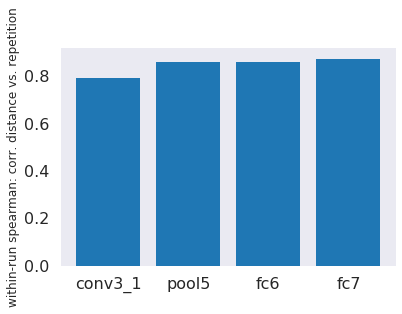

In [972]:
## get layerwise sketch differentiation correlation scores
## as of 11/2/17 earlier feature extraction step still buggy
# layers = ['pool1','pool2','pool3','pool4','pool5','fc6','fc7']
layers = ['conv3_1','pool5','fc6','fc7']
spears = []
for layer in layers:
    _Ws = pd.read_csv('sketch_similarity_timecourse_within_run_{}.csv'.format(layer)) 
    if len(spears)==0:
        spears = _Ws.runwise_similarity_change.values
    else:
        spears = np.vstack((spears,_Ws.runwise_similarity_change.values))
Ws_all_layers = pd.DataFrame(data=spears.transpose(),columns=layers)      
plt.bar(np.arange(np.shape(Ws_all_layers)[1]),Ws_all_layers.mean())
plt.ylabel('within-run spearman: corr. distance vs. repetition',fontsize=12)
tick = plt.xticks(np.arange(4),layers) 


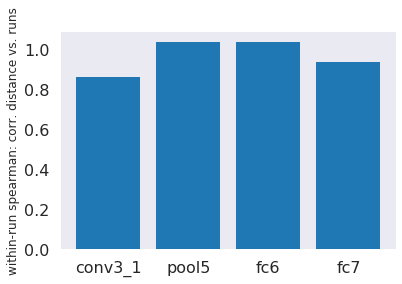

In [974]:
layers = ['conv3_1','pool5','fc6','fc7']
spears = []
for layer in layers:
    _Ws = pd.read_csv('sketch_similarity_timecourse_across_runs_{}.csv'.format(layer)) 
    if len(spears)==0:
        spears = _Ws.runwise_similarity_change.values
    else:
        spears = np.vstack((spears,_Ws.runwise_similarity_change.values))
Ws_all_layers = pd.DataFrame(data=spears.transpose(),columns=layers)      
plt.bar(np.arange(np.shape(Ws_all_layers)[1]),Ws_all_layers.mean())
plt.ylabel('within-run spearman: corr. distance vs. runs',fontsize=12)
tick = plt.xticks(np.arange(4),layers) 

In [936]:
draw_subs = W.subj.values

In [937]:
intersect_subs = np.intersect1d(neural_subs,draw_subs)
print len(intersect_subs)

32


In [938]:
draw_early = []
draw_late = []
within_run = []
for index,row in X.iterrows():
    sub = row['subj']
    draw_early.append(W[W['subj']==sub]['early_score'].values[0])
    draw_late.append(W[W['subj']==sub]['late_score'].values[0]) 
    within_run.append(Ws[Ws['subj']==sub]['runwise_similarity_change'].values[0]) 
draw_change = np.array(draw_late) - np.array(draw_early)

In [939]:
## assign convenience columns to X matrix
X = X.assign(within_run=pd.Series(within_run).values)
X = X.assign(draw_early=pd.Series(draw_early).values)
X = X.assign(draw_late=pd.Series(draw_late).values)
X = X.assign(draw_change=pd.Series(draw_change).values)
X = X.assign(diffscore_V1=pd.Series(diffscore_V1).values)
X = X.assign(diffscore_fusiform=pd.Series(diffscore_fusiform).values)
X = X.assign(diffscore_LOC=pd.Series(diffscore_LOC).values)
X = X.assign(diffscore_IT=pd.Series(diffscore_IT).values)
X = X.assign(diffscore_IT_V1=pd.Series(diffscore_IT_V1).values)
X = X.assign(diffscore_occitemp=pd.Series(diffscore_occitemp).values)
if 'trained_post_parahippo' in X.columns:
    X = X.assign(diffscore_parahippo=pd.Series(diffscore_parahippo).values)
if 'trained_post_ventemp' in X.columns:
    X = X.assign(diffscore_ventemp=pd.Series(diffscore_ventemp).values)    
    X = X.assign(diffscore_ventemp_V1=pd.Series(diffscore_ventemp_V1).values)
if 'trained_post_occipital' in X.columns:
    X = X.assign(diffscore_occipital=pd.Series(diffscore_occipital).values)            
    X = X.assign(diffscore_ventemp_occipital=pd.Series(diffscore_ventemp_occipital).values)                

(-0.038589088574795996, 0.83391294212965417)
SpearmanrResult(correlation=0.016780690557299641, pvalue=0.92736906845143241)


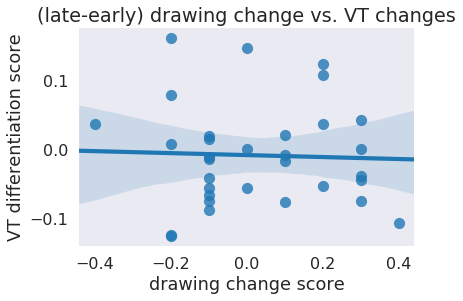

In [940]:
### overall recognizability (classifier accuracy) difference between first 20 drawings and final 20 drawings
sns.set_context('poster')
sns.regplot(x="draw_change",y="diffscore_ventemp",data=X)
plt.title('(late-early) drawing change vs. VT changes')
plt.ylabel('VT differentiation score')
plt.xlabel('drawing change score')
print stats.pearsonr(diffscore_ventemp,draw_change)
print stats.spearmanr(diffscore_ventemp,draw_change)

IT changes
(-0.027389648945488489, 0.8817094452286186)
SpearmanrResult(correlation=-0.046242807461311916, pvalue=0.80157013383983444)
LOC changes
(-0.093659886294604658, 0.61014667845167947)
SpearmanrResult(correlation=-0.043673762602350147, pvalue=0.81239316432676689)
V1 changes
(0.059719723896914725, 0.74542705100824602)
SpearmanrResult(correlation=-0.0018350320421155523, pvalue=0.99204721823645514)
Occipitotemporal changes
(-0.067173741123788308, 0.71489735508672547)
SpearmanrResult(correlation=-0.041104717743388371, pvalue=0.82325031463513931)


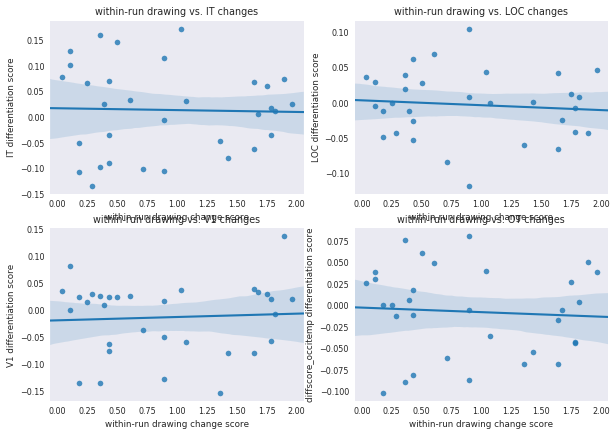

In [941]:
### within_run: ranges from (0, 2). positive values indicate increasing feature differentiation across trials within-run. 
sns.set_context('paper')
fig = plt.figure(figsize=(10,7))

plt.subplot(221)
sns.regplot(x="within_run",y="diffscore_IT",data=X)
plt.title('within-run drawing vs. IT changes')
plt.ylabel('IT differentiation score')
plt.xlabel('within-run drawing change score')
print 'IT changes'
print stats.pearsonr(diffscore_IT,within_run)
print stats.spearmanr(diffscore_IT,within_run)

plt.subplot(222)
sns.regplot(x="within_run",y="diffscore_LOC",data=X)
plt.title('within-run drawing vs. LOC changes')
plt.ylabel('LOC differentiation score')
plt.xlabel('within-run drawing change score')
print 'LOC changes'
print stats.pearsonr(diffscore_LOC,within_run)
print stats.spearmanr(diffscore_LOC,within_run)

plt.subplot(223)
sns.regplot(x="within_run",y="diffscore_V1",data=X)
plt.title('within-run drawing vs. V1 changes')
plt.ylabel('V1 differentiation score')
plt.xlabel('within-run drawing change score')
print 'V1 changes'
print stats.pearsonr(diffscore_V1,within_run)
print stats.spearmanr(diffscore_V1,within_run)

plt.subplot(224)
sns.regplot(x="within_run",y="diffscore_occitemp",data=X)
plt.title('within-run drawing vs. OT changes')
plt.ylabel('diffscore_occitemp differentiation score')
plt.xlabel('within-run drawing change score')
print 'Occipitotemporal changes'
print stats.pearsonr(diffscore_occitemp,within_run)
print stats.spearmanr(diffscore_occitemp,within_run)

In [ ]:
if 'trained_post_parahippo' in X.columns:
    fig = plt.figure(figsize=(4,4))
    sns.set_context('poster')
    sns.regplot(x="within_run",y="diffscore_parahippo",data=X)
    plt.title('within-run drawing vs. parahippo changes')
    plt.ylabel('parahippo differentiation score')
    plt.xlabel('within-run drawing change score')
    print stats.pearsonr(diffscore_parahippo,within_run)
    print stats.spearmanr(diffscore_parahippo,within_run)

(-0.319270855959019, 0.074886443306913936)
SpearmanrResult(correlation=-0.41361622229284545, pvalue=0.018614908382942809)


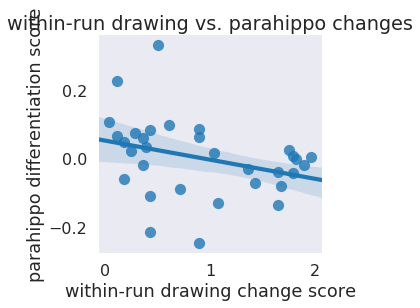

In [942]:
if 'trained_post_parahippo' in X.columns:
    fig = plt.figure(figsize=(4,4))
    sns.set_context('poster')
    sns.regplot(x="within_run",y="diffscore_parahippo",data=X)
    plt.title('within-run drawing vs. parahippo changes')
    plt.ylabel('parahippo differentiation score')
    plt.xlabel('within-run drawing change score')
    print stats.pearsonr(diffscore_parahippo,within_run)
    print stats.spearmanr(diffscore_parahippo,within_run)

(-0.19179939371028065, 0.29297530337600719)
SpearmanrResult(correlation=-0.14001294481341667, pvalue=0.44468994946800622)


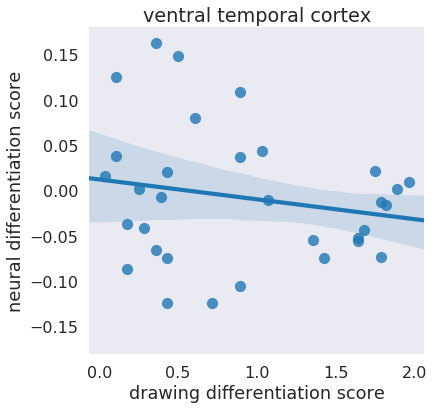

In [943]:
if 'trained_post_ventemp' in X.columns:
    fig = plt.figure(figsize=(6,6))
    sns.set_context('poster')
    sns.regplot(x="within_run",y="diffscore_ventemp",data=X)
    plt.title('ventral temporal cortex')
    plt.ylabel('neural differentiation score')
    plt.xlabel('drawing differentiation score')
    plt.ylim(-0.18,0.18)    
    print stats.pearsonr(diffscore_ventemp,within_run)
    print stats.spearmanr(diffscore_ventemp,within_run)
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    plt.savefig('./plots/correlation_ventemp_drawing_changes_scatter.pdf')    

(0.030914190189905957, 0.86661527025730745)
SpearmanrResult(correlation=0.035599621617041714, pvalue=0.84662159936978276)


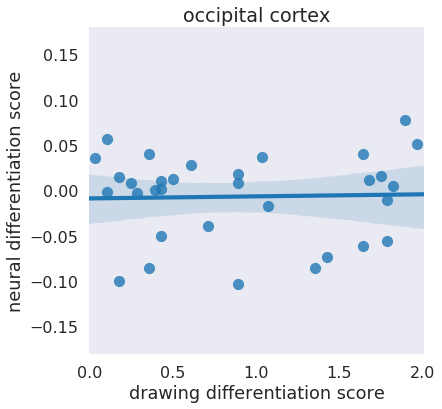

In [944]:
if 'trained_post_occipital' in X.columns:
    fig = plt.figure(figsize=(6,6))
    sns.set_context('poster')
    sns.regplot(x="within_run",y="diffscore_occipital",data=X)
    plt.title('occipital cortex')
    plt.ylabel('neural differentiation score')
    plt.xlabel('drawing differentiation score')
    plt.xlim(-0,2.01)
    plt.ylim(-0.18,0.18)    
    print stats.pearsonr(diffscore_occipital,within_run)
    print stats.spearmanr(diffscore_occipital,within_run)
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    plt.savefig('./plots/correlation_occ_drawing_changes_scatter.pdf')     

(-0.073570836751664967, 0.6890353738609839)
SpearmanrResult(correlation=-0.10129376872477848, pvalue=0.58120275394772336)


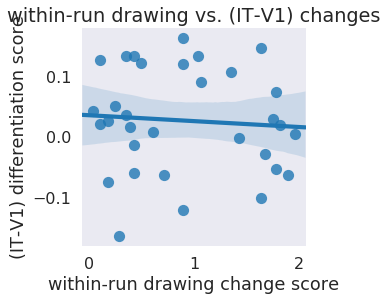

In [945]:
### within_run: ranges from (0, 2). positive values indicate increasing feature differentiation across trials within-run. 
fig = plt.figure(figsize=(4,4))
sns.set_context('poster')
sns.regplot(x="within_run",y="diffscore_IT_V1",data=X)
plt.title('within-run drawing vs. (IT-V1) changes')
plt.ylabel('(IT-V1) differentiation score')
plt.xlabel('within-run drawing change score')
print stats.pearsonr(diffscore_IT_V1,within_run)
print stats.spearmanr(diffscore_IT_V1,within_run)

(-0.22697279331980033, 0.21157355381660303)
SpearmanrResult(correlation=-0.19396288685161386, pvalue=0.28746058776701428)


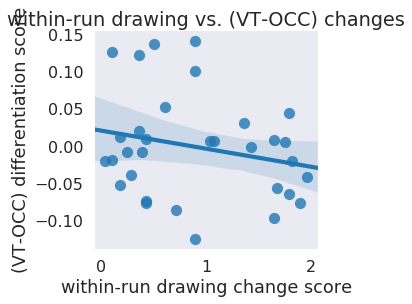

In [946]:
if 'trained_post_occipital' in X.columns:
    fig = plt.figure(figsize=(4,4))
    sns.set_context('poster')
    sns.regplot(x="within_run",y="diffscore_ventemp_occipital",data=X)
    plt.title('within-run drawing vs. (VT-OCC) changes')
    plt.ylabel('(VT-OCC) differentiation score')
    plt.xlabel('within-run drawing change score')
    print stats.pearsonr(diffscore_ventemp_occipital,within_run)
    print stats.spearmanr(diffscore_ventemp_occipital,within_run)

(-0.087918376130347461, 0.63230674507787399)
SpearmanrResult(correlation=-0.056885993305582132, pvalue=0.7571364383822905)


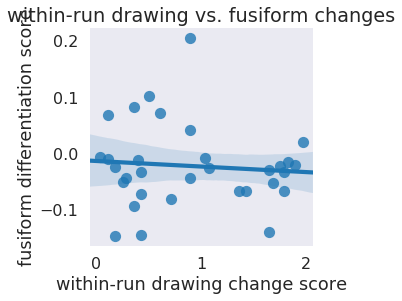

In [947]:
### within_run: ranges from (0, 2). positive values indicate increasing feature differentiation across trials within-run. 
fig = plt.figure(figsize=(4,4))
sns.set_context('poster')
sns.regplot(x="within_run",y="diffscore_fusiform",data=X)
plt.title('within-run drawing vs. fusiform changes')
plt.ylabel('fusiform differentiation score')
plt.xlabel('within-run drawing change score')
print stats.pearsonr(diffscore_fusiform,within_run)
print stats.spearmanr(diffscore_fusiform,within_run)

IT vs. V1 change mean = 0.0278473353372
Ttest_1sampResult(statistic=1.8191652829342364, pvalue=0.078557699886105323)
IT change mean = 0.0137995007439
Ttest_1sampResult(statistic=0.90725306925303817, pvalue=0.37127178927050386)
fusiform change mean = -0.0212556260778
Ttest_1sampResult(statistic=-1.6469239301390357, pvalue=0.10967530945968211)


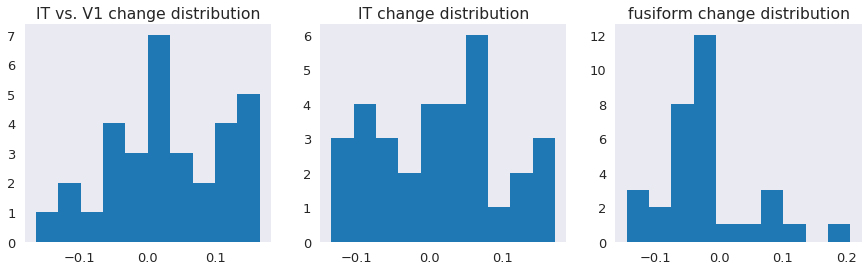

In [948]:
sns.set_context('talk')
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.title('IT vs. V1 change distribution')
h = plt.hist(diffscore_IT-diffscore_V1)
print 'IT vs. V1 change mean = ' + str(np.mean(diffscore_IT-diffscore_V1))
print stats.ttest_1samp(diffscore_IT-diffscore_V1,0)

plt.subplot(132)
h = plt.hist(diffscore_IT)
plt.title('IT change distribution')
print 'IT change mean = ' + str(np.mean(diffscore_IT))
print stats.ttest_1samp(diffscore_IT,0)

plt.subplot(133)
h = plt.hist(diffscore_fusiform)
plt.title('fusiform change distribution')
print 'fusiform change mean = ' + str(np.mean(diffscore_fusiform))
print stats.ttest_1samp(diffscore_fusiform,0)

parahippo change mean = 0.00224996970596
Ttest_1sampResult(statistic=0.1120036000521081, pvalue=0.91154265842415794)


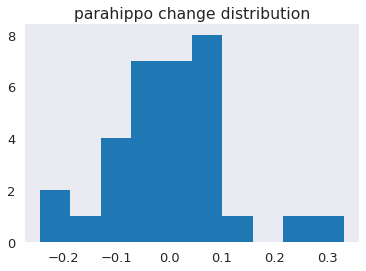

In [949]:
if 'trained_post_parahippo' in X.columns:
    h = plt.hist(diffscore_parahippo)
    plt.title('parahippo change distribution')
    print 'parahippo change mean = ' + str(np.mean(diffscore_parahippo))
    print stats.ttest_1samp(diffscore_parahippo,0)

ventemp change mean = -0.00756997373792
Ttest_1sampResult(statistic=-0.57626116430202035, pvalue=0.56859936769064778)


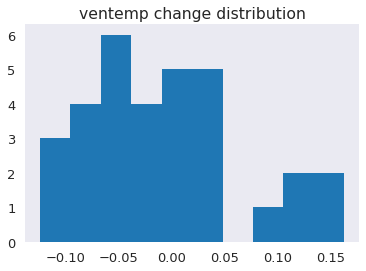

In [864]:
if 'trained_post_ventemp' in X.columns:
    h = plt.hist(diffscore_ventemp)
    plt.title('ventemp change distribution')
    print 'ventemp change mean = ' + str(np.mean(diffscore_ventemp))
    print stats.ttest_1samp(diffscore_ventemp,0)

In [950]:
## restructure dataframe to make it friendly for statsmodels
phase = np.array([0]*len(X)+[1]*len(X))
subjs2 = np.array(np.tile(X.subj.values,2))
trained_V1 = np.hstack((X['trained_pre_V1'].values, X['trained_post_V1'].values))
trained_fusiform = np.hstack((X['trained_pre_fusiform'].values, X['trained_post_fusiform'].values))
trained_LOC = np.hstack((X['trained_pre_LOC'].values, X['trained_post_LOC'].values))
trained_IT = np.hstack((X['trained_pre_IT'].values, X['trained_post_IT'].values))
trained_occitemp = np.hstack((X['trained_pre_occitemp'].values, X['trained_post_occitemp'].values))
if 'trained_post_ventemp' in X.columns:
    trained_ventemp = np.hstack((X['trained_pre_ventemp'].values, X['trained_post_ventemp'].values))
if 'trained_post_occipital' in X.columns:
    trained_occipital = np.hstack((X['trained_pre_occipital'].values, X['trained_post_occipital'].values))
if 'trained_post_parahippo' in X.columns:
    trained_parahippo = np.hstack((X['trained_pre_parahippo'].values, X['trained_post_parahippo'].values))

control_V1 = np.hstack((X['control_pre_V1'].values, X['control_post_V1'].values))
control_fusiform = np.hstack((X['control_pre_fusiform'].values, X['control_post_fusiform'].values))
control_LOC = np.hstack((X['control_pre_LOC'].values, X['control_post_LOC'].values))
control_IT = np.hstack((X['control_pre_IT'].values, X['control_post_IT'].values))
control_occitemp = np.hstack((X['control_pre_occitemp'].values, X['control_post_occitemp'].values))
if 'trained_post_ventemp' in X.columns:
    control_ventemp = np.hstack((X['control_pre_ventemp'].values, X['control_post_ventemp'].values))
if 'trained_post_occipital' in X.columns:
    control_occipital = np.hstack((X['control_pre_occipital'].values, X['control_post_occipital'].values))
if 'trained_post_parahippo' in X.columns:
    control_parahippo = np.hstack((X['control_pre_parahippo'].values, X['control_post_parahippo'].values))

diff_V1 = trained_V1-control_V1
diff_fusiform = trained_fusiform-control_fusiform
diff_LOC = trained_LOC-control_LOC
diff_IT = trained_IT-control_IT
diff_occitemp = trained_occitemp-control_occitemp
diff_IT_V1 = diff_IT - diff_V1
if 'trained_post_ventemp' in X.columns:
    diff_ventemp = trained_ventemp-control_ventemp        
    diff_ventemp_V1 = diff_ventemp - diff_V1
if 'trained_post_occipital' in X.columns:
    diff_occipital = trained_occipital-control_occipital   
if 'trained_post_parahippo' in X.columns:
    diff_parahippo = trained_parahippo-control_parahippo
    

In [951]:
if not 'trained_post_occipital' in X.columns:

    Y = pd.DataFrame([subjs2,phase,trained_V1,trained_fusiform,trained_LOC,trained_IT,
                    control_V1,control_fusiform,control_LOC,control_IT,
                    diff_V1,diff_fusiform,diff_LOC,diff_IT,diff_IT_V1,diff_occitemp])
    Y = Y.transpose()
    Y.columns = ['subj','phase','trained_V1','trained_fusiform','trained_LOC','trained_IT',
                'control_V1','control_fusiform','control_LOC','control_IT',
                'diff_V1','diff_fusiform','diff_LOC','diff_IT','diff_IT_V1','diff_occitemp']

else:    
    Y = pd.DataFrame([subjs2,phase,trained_V1,trained_fusiform,trained_LOC,trained_IT,
                    control_V1,control_fusiform,control_LOC,control_IT,
                    diff_V1,diff_fusiform,diff_LOC,diff_IT,diff_IT_V1,diff_occitemp,
                    diff_parahippo,diff_occipital,diff_ventemp])
    Y = Y.transpose()
    Y.columns = ['subj','phase','trained_V1','trained_fusiform','trained_LOC','trained_IT',
                'control_V1','control_fusiform','control_LOC','control_IT',
                'diff_V1','diff_fusiform','diff_LOC','diff_IT','diff_IT_V1','diff_occitemp',
                'diff_parahippo','diff_occipital','diff_ventemp']

In [952]:
Y['phase'] = Y['phase'].astype(int)
Y['phase_ord'] = pd.Categorical(Y.phase).codes
Y['diff_IT'] = Y['diff_IT'].astype(float)
Y['diff_V1'] = Y['diff_V1'].astype(float)
Y['diff_fusiform'] = Y['diff_fusiform'].astype(float)
Y['diff_occitemp'] = Y['diff_occitemp'].astype(float)
Y['diff_LOC'] = Y['diff_LOC'].astype(float)
Y['diff_IT_V1'] = Y['diff_IT_V1'].astype(float)
if 'trained_post_occipital' in X.columns:
    Y['diff_occipital'] = Y['diff_occipital'].astype(float)    
    Y['diff_ventemp'] = Y['diff_ventemp'].astype(float)   
    Y['diff_parahippo'] = Y['diff_parahippo'].astype(float)    
    

In [953]:
import statsmodels.formula.api as smf
md = smf.mixedlm("diff_IT_V1 ~ C(phase)", Y, groups=Y['subj'])
mdf = md.fit()
mdf.summary()

/home/jefan/.local/lib/python2.7/site-packages/statsmodels/regression/mixed_linear_model.py:2019: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: diff_IT_V1
No. Observations: 64      Method:             REML      
No. Groups:       32      Scale:              0.0037    
Min. group size:  2       Likelihood:         81.0293   
Max. group size:  2       Converged:          Yes       
Mean group size:  2.0                                   
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     -0.019    0.011 -1.718 0.086 -0.040  0.003
C(phase)[T.1]  0.028    0.015  1.819 0.069 -0.002  0.058
groups RE      0.000    0.012                           
========================================================

"""

In [954]:
def r_to_z(r):
    return math.log((1 + r) / (1 - r)) / 2.0

def z_to_r(z):
    e = math.exp(2 * z)
    return((e - 1) / (e + 1))

def r_confidence_interval(r, alpha, n):
    z = r_to_z(r)
    se = 1.0 / math.sqrt(n - 3)
    z_crit = stats.norm.ppf(1 - alpha/2)  # 2-tailed z critical value

    lo = z - z_crit * se
    hi = z + z_crit * se

    # Return a sequence
    return (z_to_r(lo), z_to_r(hi))

def get_r_CIs(vals,N):
    ci = []
    lerr = []
    uerr = []
    for v in vals:
        ci.append(r_confidence_interval(v,0.05,N))
        lerr.append(v - r_confidence_interval(v,0.05,N)[0])
        uerr.append(r_confidence_interval(v,0.05,N)[1] - v) 
    ERRBAR = np.vstack((lerr,uerr))        
    CI = np.array(ci).transpose()
    return CI, ERRBAR

In [955]:
r_V1 = stats.pearsonr(diffscore_V1,within_run)[0]
r_LOC = stats.pearsonr(diffscore_LOC,within_run)[0]
r_fusiform = stats.pearsonr(diffscore_fusiform,within_run)[0]
r_parahippo = stats.pearsonr(diffscore_parahippo,within_run)[0]
r_IT = stats.pearsonr(diffscore_IT,within_run)[0]    
if 'trained_post_occipital' in X.columns:
    r_ventemp = stats.pearsonr(diffscore_ventemp,within_run)[0]
    r_occipital = stats.pearsonr(diffscore_occipital,within_run)[0]
    vals = [r_V1, r_LOC, r_IT, r_fusiform, r_parahippo, r_occipital, r_ventemp]
else:
    vals = [r_V1, r_LOC, r_IT, r_fusiform, r_parahippo]

CI,ERRBAR = get_r_CIs(vals,len(diffscore_V1))

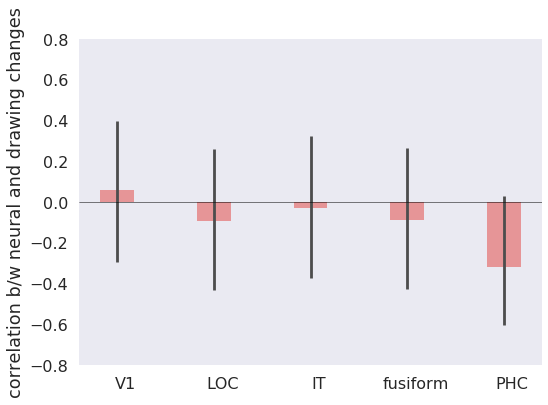

In [957]:
sns.set_style('dark')
sns.set_context('poster')
fig = plt.figure(figsize=(8,6))

n_groups = 5 # num ROIs
index = np.arange(n_groups)
bar_width = 0.35

_vals = vals[:5]
_ERRBAR = ERRBAR[:,:5]

opacity = 0.8
error_config = {'ecolor': '0.3'}

rects = plt.bar(index, _vals, bar_width,
                 alpha=opacity,
                 color=(0.9,0.5,0.5),
                 yerr=_ERRBAR,
                 error_kw=error_config)
tick = plt.xticks(index + bar_width / 4, ('V1','LOC','IT','fusiform','PHC'))
# plt.title('neural vs drawing differentiation')
plt.ylabel('correlation b/w neural and drawing changes')
plt.axhline(y=0,color='k',linewidth=0.5)
plt.ylim(-0.8,0.8)
plt.tight_layout()
if not os.path.exists('./plots'):
    os.makedirs('./plots')
plt.savefig('./plots/correlation_neural_drawing_changes_allrois_{}.pdf'.format(which_feat))

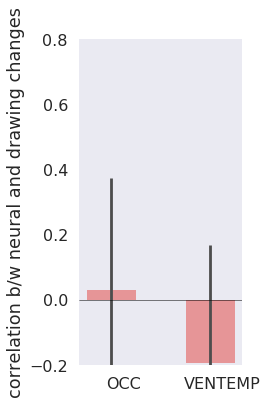

In [958]:
if 'trained_post_occipital' in X.columns:

    sns.set_style('dark')
    sns.set_context('poster')
    fig = plt.figure(figsize=(4,6))

    n_groups = 2 # num ROIs
    index = np.arange(n_groups)
    bar_width = 0.5

    _vals = vals[5:]
    _ERRBAR = ERRBAR[:,5:]

    opacity = 0.8
    error_config = {'ecolor': '0.3'}

    rects = plt.bar(index, _vals, bar_width,
                     alpha=opacity,
                     color=(0.9,0.5,0.5),
                     yerr=_ERRBAR,
                     error_kw=error_config)
    tick = plt.xticks(index + bar_width / 4, ('OCC','VENTEMP'))
#     plt.title('neural and drawing differentiation')
    plt.ylabel('correlation b/w neural and drawing changes')
    plt.axhline(y=0,color='k',linewidth=0.5)
    plt.ylim(-0.2,0.8)
    plt.tight_layout()
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    plt.savefig('./plots/correlation_neural_drawing_changes_bylobe_{}.pdf'.format(which_feat))

## Plot overall neural changes by ROI

In [752]:
yvals = np.vstack((X.diffscore_V1.values,X.diffscore_LOC,X.diffscore_IT,X.diffscore_fusiform,X.diffscore_parahippo)).transpose().mean(0)
sem = np.vstack((X.diffscore_V1.values,X.diffscore_LOC,X.diffscore_IT,X.diffscore_fusiform,X.diffscore_parahippo)).transpose().std(0)/np.sqrt(len(X.diffscore_V1.values))

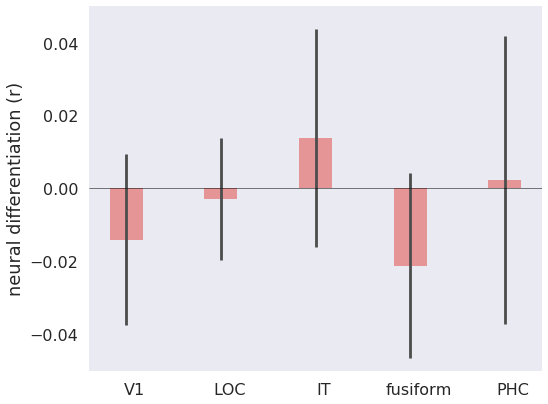

In [820]:
fig = plt.figure(figsize=(8,6))
n_groups = len(yvals) # num ROIs
bar_width = 0.35
index = np.arange(n_groups)
opacity = 0.8
error_config = {'ecolor': '0.3'}
errbar = sem*2
plt.ylim([-0.05,0.05])
plt.ylabel('neural differentiation (r)')
plt.axhline(y=0,color='k',linewidth=0.5)
rects = plt.bar(index, yvals, bar_width,
                 alpha=opacity,
                 color=(0.9,0.5,0.5),
                 yerr=errbar,
                 error_kw=error_config)
tick = plt.xticks(index + bar_width / 4, ('V1','LOC','IT','fusiform','PHC'))
plt.tight_layout()
plt.savefig('./plots/neural_changes_by_roi.pdf')